## ResNet50 + ArcFace

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import optimizers

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import math

from sklearn.metrics import accuracy_score

In [2]:
trainImagePath = '../dataSet/splitImages/train'
validationImagePath = '../dataSet/splitImages/val'
testImagePath = '../dataSet/splitImages/test'
checkpointPath = '../checkpoints/epoch_{epoch:04d}.ckpt'
logsPath = '../logs/fit/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bestCheckpointPath = '../model/best'

batchSize = 32
imageWidth = 224
imageHeight = 225
imageChannel = 3
input_shape = (imageWidth, imageHeight, imageChannel)
n_classes = 44
scale = 30
margin = 0.3
dropout_rate = 0.0
dense_units=512



In [3]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m
    
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             'n_classes':self.n_classes,
#             's':self.s,
#             'm':self.m,
#             'ls_eps':self.ls_eps,
#             'easy_margin':self.easy_margin,
#             'cos_m':self.cos_m,
#             'sin_m':self.sin_m,
#             'th':self.th,
#             'mm':self.mm
#         })
#         return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [4]:
class Dataset(Sequence) :
    
    def __init__(self,generator) :
        self.generator = generator
    def __len__(self) :
        return len(self.generator)
    def __getitem__(self,idx) :
        x = self.generator[idx] [0]
        y = np.argmax(self.generator[idx] [1],axis=1)
        return (x,y),y

### 이미지 데이터 생성

ImageDataGenerator (train, validation)

In [5]:
trainDataGen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=20,
                                  zoom_range=0.3,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  brightness_range=[0.7, 1.3],
                                  fill_mode='nearest',
                                  )

train set

In [6]:
trainGenSet = trainDataGen.flow_from_directory(
    trainImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical',
    shuffle=True
)

Found 5601 images belonging to 44 classes.


validation set

In [7]:
validationGenSet = trainDataGen.flow_from_directory(
    validationImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 681 images belonging to 44 classes.


ImageDataGenerator (train, validation)

In [8]:
testDataGen = ImageDataGenerator(rescale=1./255)

test set

In [9]:
testGenSet = testDataGen.flow_from_directory(
    testImagePath,
    batch_size=batchSize,
    target_size=(imageWidth,imageHeight),
    class_mode='categorical'
)

Found 739 images belonging to 44 classes.


In [10]:
backbone = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=input_shape,
        weights=('imagenet')
    )

pooling = tf.keras.layers.GlobalAveragePooling2D(name='head/pooling')
dropout = tf.keras.layers.Dropout(dropout_rate, name='head/dropout')
dense = tf.keras.layers.Dense(dense_units, name='head/dense')

margin = ArcMarginProduct(
            n_classes = n_classes, 
            s = 30, 
            m = 0.5, 
            name='head/arc_margin', 
            dtype='float32'
            )

inp = tf.keras.layers.Input(shape = input_shape, name = 'inp1')
label = tf.keras.layers.Input((), name = 'inp2')

x = backbone(inp)
x = pooling(x)
x = dropout(x)
x = dense(x)
x = margin([x, label])
output = Dense(44, activation='softmax')(x)

model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])

model.summary()

2022-06-15 02:26:35.168854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 02:26:35.281411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 02:26:35.281734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 02:26:35.282847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 224, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 8, 2048)   23587712    ['inp1[0][0]']                   
                                                                                                  
 head/pooling (GlobalAveragePoo  (None, 2048)        0           ['resnet50[0][0]']               
 ling2D)                                                                                          
                                                                                              

In [11]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [12]:
checkpointPath = '../checkpoints/epoch_{epoch:04d}.ckpt'

In [13]:
checkpoint = ModelCheckpoint(
                        checkpointPath, monitor='val_loss', verbose=0, save_best_only=False,
                        save_weights_only=False, mode='auto', save_freq='epoch'
                    )


In [14]:
earlyStopping = [
                    EarlyStopping(monitor='val_loss',verbose=0, patience=10, ),
                    ModelCheckpoint( bestCheckpointPath, monitor='val_loss', save_best_only=True )
                ]

In [15]:
tensorboard = tf.keras.callbacks.TensorBoard(logsPath)

In [16]:
trainDataSet = Dataset(trainGenSet)
valDataSet = Dataset(validationGenSet)

In [17]:
epochs = 200
history = model.fit(
    trainDataSet,
    epochs=epochs,
    validation_data=valDataSet,
    callbacks=[checkpoint,earlyStopping, tensorboard],
    verbose=1
)

Layer ArcMarginProduct has arguments ['self', 'n_classes', 's', 'm', 'easy_margin', 'ls_eps']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/200


2022-06-15 02:26:58.267221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


176/176 [==============================] - ETA: 0s - loss: 1.0706 - accuracy: 0.7800

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0001.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0001.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1164s 7s/step - loss: 1.0706 - accuracy: 0.7800 - val_loss: 10.8960 - val_accuracy: 0.0602
Epoch 2/200
176/176 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.8923

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0002.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0002.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1190s 7s/step - loss: 0.4748 - accuracy: 0.8923 - val_loss: 10.3816 - val_accuracy: 0.0264
Epoch 3/200
176/176 [==============================] - ETA: 0s - loss: 0.1004 - accuracy: 0.9741

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0003.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0003.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1111s 6s/step - loss: 0.1004 - accuracy: 0.9741 - val_loss: 9.8066 - val_accuracy: 0.0073
Epoch 4/200
176/176 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9868

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0004.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0004.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1114s 6s/step - loss: 0.0603 - accuracy: 0.9868 - val_loss: 8.9743 - val_accuracy: 0.0382
Epoch 5/200
176/176 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9968

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0005.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0005.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1127s 6s/step - loss: 0.0138 - accuracy: 0.9968 - val_loss: 3.8975 - val_accuracy: 0.3818
Epoch 6/200
176/176 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9925

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0006.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0006.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1118s 6s/step - loss: 0.0253 - accuracy: 0.9925 - val_loss: 1.9640 - val_accuracy: 0.7034
Epoch 7/200
176/176 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9932

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0007.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0007.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1114s 6s/step - loss: 0.0288 - accuracy: 0.9932 - val_loss: 0.7455 - val_accuracy: 0.8267
Epoch 8/200
176/176 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9914

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0008.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0008.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1122s 6s/step - loss: 0.0258 - accuracy: 0.9914 - val_loss: 0.1519 - val_accuracy: 0.9559
Epoch 9/200
176/176 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9961

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0009.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0009.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1123s 6s/step - loss: 0.0117 - accuracy: 0.9961 - val_loss: 0.0085 - val_accuracy: 0.9956
Epoch 10/200
176/176 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 0.9998

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0010.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0010.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1114s 6s/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 5.4512e-04 - val_accuracy: 1.0000
Epoch 11/200
176/176 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9980

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0011.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0011.ckpt/assets


176/176 [==============================] - 1095s 6s/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 1.3525 - val_accuracy: 0.7239
Epoch 12/200
176/176 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9936

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0012.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0012.ckpt/assets


176/176 [==============================] - 1097s 6s/step - loss: 0.0243 - accuracy: 0.9936 - val_loss: 1.4493 - val_accuracy: 0.7460
Epoch 13/200
176/176 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9927

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0013.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0013.ckpt/assets


176/176 [==============================] - 1106s 6s/step - loss: 0.0208 - accuracy: 0.9927 - val_loss: 0.2927 - val_accuracy: 0.9295
Epoch 14/200
176/176 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9923

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0014.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0014.ckpt/assets


176/176 [==============================] - 1086s 6s/step - loss: 0.0333 - accuracy: 0.9923 - val_loss: 0.5116 - val_accuracy: 0.8972
Epoch 15/200
176/176 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9913

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0015.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0015.ckpt/assets


176/176 [==============================] - 1094s 6s/step - loss: 0.0353 - accuracy: 0.9913 - val_loss: 0.0239 - val_accuracy: 0.9912
Epoch 16/200
176/176 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9998

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0016.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0016.ckpt/assets


INFO:tensorflow:Assets written to: ../model/best/assets


INFO:tensorflow:Assets written to: ../model/best/assets


176/176 [==============================] - 1108s 6s/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 3.0474e-04 - val_accuracy: 1.0000
Epoch 17/200
176/176 [==============================] - ETA: 0s - loss: 7.3692e-04 - accuracy: 0.9996

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0017.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0017.ckpt/assets


176/176 [==============================] - 1101s 6s/step - loss: 7.3692e-04 - accuracy: 0.9996 - val_loss: 7.5200e-04 - val_accuracy: 1.0000
Epoch 18/200
176/176 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9995

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0018.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0018.ckpt/assets


176/176 [==============================] - 1127s 6s/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.0106 - val_accuracy: 0.9971
Epoch 19/200
176/176 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9975

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0019.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0019.ckpt/assets


176/176 [==============================] - 1101s 6s/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.0935 - val_accuracy: 0.9677
Epoch 20/200
176/176 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9982

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0020.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0020.ckpt/assets


176/176 [==============================] - 1079s 6s/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 0.0592 - val_accuracy: 0.9838
Epoch 21/200
176/176 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000    

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0021.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0021.ckpt/assets


176/176 [==============================] - 1085s 6s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0183 - val_accuracy: 0.9956
Epoch 22/200
176/176 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9975

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0022.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0022.ckpt/assets


176/176 [==============================] - 1105s 6s/step - loss: 0.0107 - accuracy: 0.9975 - val_loss: 0.8678 - val_accuracy: 0.7680
Epoch 23/200
176/176 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9948

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0023.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0023.ckpt/assets


176/176 [==============================] - 1094s 6s/step - loss: 0.0211 - accuracy: 0.9948 - val_loss: 0.8980 - val_accuracy: 0.7915
Epoch 24/200
176/176 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9880

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0024.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0024.ckpt/assets


176/176 [==============================] - 1114s 6s/step - loss: 0.0431 - accuracy: 0.9880 - val_loss: 1.0624 - val_accuracy: 0.7959
Epoch 25/200
176/176 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9982

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0025.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0025.ckpt/assets


176/176 [==============================] - 1091s 6s/step - loss: 0.0109 - accuracy: 0.9982 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 26/200
176/176 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9998

INFO:tensorflow:Assets written to: ../checkpoints/epoch_0026.ckpt/assets


INFO:tensorflow:Assets written to: ../checkpoints/epoch_0026.ckpt/assets


176/176 [==============================] - 1091s 6s/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0336 - val_accuracy: 0.9927


In [19]:
testDataSet = Dataset(testGenSet)
scores = model.evaluate(testDataSet)
print(scores)

24/24 [==============================] - 110s 5s/step - loss: 0.0278 - accuracy: 0.9919
[0.027843991294503212, 0.9918808937072754]


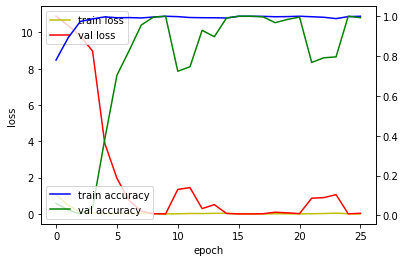

In [20]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

In [21]:
model.save('../model/resnetArcfacetModel')

INFO:tensorflow:Assets written to: ../model/resnetArcfacetModel/assets


INFO:tensorflow:Assets written to: ../model/resnetArcfacetModel/assets
